<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/35_Pro_%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8_(%D0%A3%D0%BD%D0%B8%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%82%D0%B5%D1%82_%D0%B8%D1%81%D0%BA%D1%83%D1%81%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B8%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82%D0%B0)%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Pro

Макс 10 баллов

Добейтесь средней точности 91-92% в задаче поиска мошеннических операций. Для этого попробуйте сделать более мощный автокодировщик и гибкую настройку порога (bias), по которому мы определяем, мошенническая транзакция или нет

Постройте на одном графике 2 гистограммы (density=True) для нормальных и мошеннических транзакций. По графику определите 3 порога:

1) при котором все мошеннические транзакции будут пойманы

2) “оптимальный порог” - на пересечении распределений

3) при котором ни одна нормальная транзакция не будет распознана, как мошенническая

# Загрузка данных


In [ ]:
from tensorflow.keras.models import Model, Sequential # загружаем абстрактный класс базовой модели сети от кераса и последовательную модель
# Из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K # подтягиваем базовые керасовские функции
from tensorflow.keras.optimizers import Adam # загружаем выбранный оптимизатор
from tensorflow.keras import utils # загружаем утилиты кераса
from tensorflow.keras.datasets import mnist, fashion_mnist # загружаем готовые базы mnist
from tensorflow.keras.callbacks import LambdaCallback

import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображения
import numpy as np # библиотека для работы с массивами данных
import pandas as pd # библиотека для анализа и обработки данных
from PIL import Image # модуль для отрисовки изображения
from sklearn.model_selection import train_test_split # модуль для разбивки выборки на тренировочную/тестовую
from sklearn.preprocessing import StandardScaler # модуль для стандартизации данных

import os #
from google.colab import drive #модуль для работы с google диском 
import time, random
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
drive.mount('/content/drive/') # монтируем google диск

Mounted at /content/drive/


In [ ]:
# Функция для расчета mse
def getMSE(x1, x2): # создадим функцию среднеквадратичной ошибки
  x1 = x1.flatten() # сплющиваем в одномерный вектор
  x2 = x2.flatten() # сплющиваем в одномерный вектор
  delta = x1 - x2 # находим разницу
  return sum(delta ** 2) / len(delta) # и возвращаем сумму квадратов разницы, делённую на длину разницы

In [ ]:
# Зададим пару массивов и проверим работу функции
x1 = np.array([1, 1, 1]) # создаем первый массив
x2 = np.array([1, 1, 1]) # создаем второй массив
print(getMSE(x1,x2)) # выведем ошибку полученную нашей функцией

0.0


In [ ]:
# Зададим пару массивов и проверим работу функции
x1 = np.array([1, 1, 1, 1]) # создаем первый массив
x2 = np.array([1, 1, 0, 0]) # создаем второй массив
print(getMSE(x1,x2)) # выведем ошибку полученную нашей функцией

0.5


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Базы/creditcard.csv') # читаем базу

In [ ]:
df.head() # выводим первые пять строк

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Удаляем столбец со временем
data = df.drop(['Time'], axis=1)
# Нормализуем столбец с суммой транзакции
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

frauds = data[data.Class == 1] # записываем мошеннические операции
normal = data[data.Class == 0] # записываем нормальные операции

In [ ]:
frauds.shape # смотрим какие размеры у мошеннических операций

(492, 30)

In [ ]:
normal.shape # смотрим какие размеры у нормальных операций

(284315, 30)

In [ ]:
RANDOM_SEED = 42 # задаем случайное значение
# берём нормальные операции и разбиваем на train_test(только 'X')
X_train, X_test = train_test_split(normal, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# Удаляем класс в обучающем наборе данных
X_train = X_train.drop(['Class'], axis=1)
# Добавляем все мошеннические транзакции в тестовый набор данных
X_test = pd.concat([X_test, frauds])
# Делаем метки для тестового набора данных
y_test = X_test['Class']
# Удаляем класс у тестового набора данных
X_test = X_test.drop(['Class'], axis=1)
# Преобразуем данные в массивы numpy
X_train = X_train.values
X_test = X_test.values

In [ ]:
print(X_train.shape) # взглянем на размеры обучающих данных

(227452, 29)


# Иссл.1

In [ ]:
def creditcardAutoencoder():
   
  dataSize = X_train.shape[1] 
   
  dataInput = Input(shape=(dataSize, )) 

  x = Dense(dataSize, activation='relu')(dataInput) 
  x = BatchNormalization()(x) 
  x = Dense(15, activation='relu')(x) 
  x = BatchNormalization()(x) 
  x = Dense(10, activation='relu')(x) 
  x = BatchNormalization()(x) 
  x = Dense(15, activation='relu')(x) 
  x = BatchNormalization()(x) 
  x = Dense(dataSize, activation='linear')(x) 
    
  autoencoder = Model(inputs=dataInput, outputs=x) 
    
  autoencoder.compile(optimizer=Adam(0.001), loss='mse') 
  
  return autoencoder

In [ ]:
model_0 = creditcardAutoencoder()

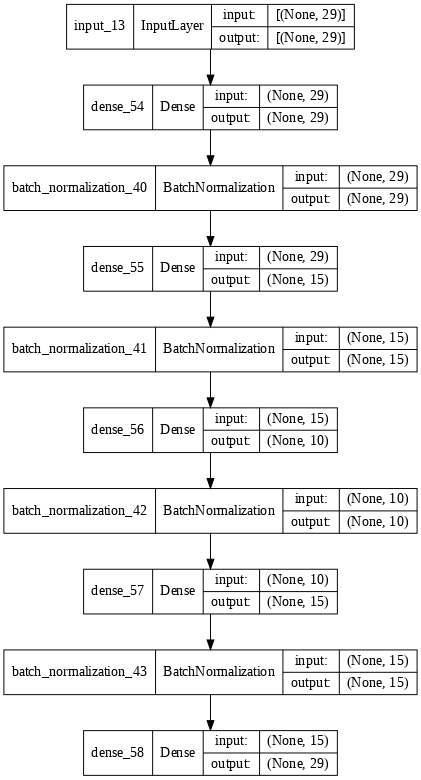

In [ ]:
utils.plot_model(model_0, show_shapes=True, dpi=70)

In [ ]:
epochs = 50
dataSize = X_train.shape[1] 
batchsize = dataSize
history = model_0.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batchsize*100)

Epoch 1/50
79/79 [==============================] - 0s 5ms/step - loss: 0.4298
Epoch 2/50
79/79 [==============================] - 0s 5ms/step - loss: 0.3944
Epoch 3/50
79/79 [==============================] - 0s 5ms/step - loss: 0.3671
Epoch 4/50
79/79 [==============================] - 0s 5ms/step - loss: 0.3468
Epoch 5/50
79/79 [==============================] - 0s 5ms/step - loss: 0.3316
Epoch 6/50
79/79 [==============================] - 0s 5ms/step - loss: 0.3216
Epoch 7/50
79/79 [==============================] - 0s 5ms/step - loss: 0.3127
Epoch 8/50
79/79 [==============================] - 0s 5ms/step - loss: 0.3046
Epoch 9/50
79/79 [==============================] - 0s 5ms/step - loss: 0.2993
Epoch 10/50
79/79 [==============================] - 0s 5ms/step - loss: 0.2941
Epoch 11/50
79/79 [==============================] - 0s 5ms/step - loss: 0.2877
Epoch 12/50
79/79 [==============================] - 0s 5ms/step - loss: 0.2852
Epoch 13/50
79/79 [==============================

In [ ]:
model_0.save_weights('/content/drive/MyDrive/Colab Notebooks/Базы/modelCredit.h5') # Сохраняем модель
model_0.load_weights('/content/drive/MyDrive/Colab Notebooks/Базы/modelCredit.h5') # Загружаем модель

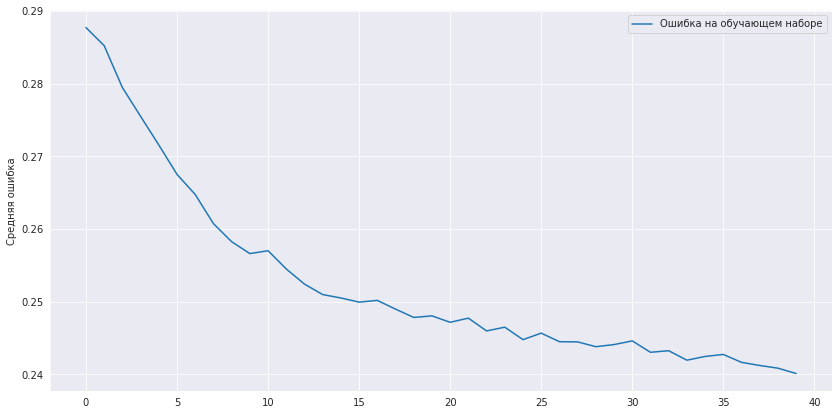

In [ ]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][10:], 
         label='Ошибка на обучающем наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
predictions = model_0.predict(X_test) # делаем предсказание по X_test

In [ ]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1) # определяем среднеквадратичную ошибку по X_test и предсказанием по X_test

In [ ]:
mse.shape

(57355,)

In [ ]:
mse_normal = mse[y_test.values == 0] # среднеквадратичная ошибка на нормальных операциях
mse_frauds = mse[y_test.values == 1] # среднеквадратичная ошибка на мошеннических операциях

In [ ]:
print(type(mse_normal), len(mse_normal))
print(type(mse_frauds), len(mse_frauds))

<class 'numpy.ndarray'> 56863
<class 'numpy.ndarray'> 492


In [ ]:
print("Минимальная ошибка нормальных транзакций:", round(min(mse_normal),4)) #найдем минимальную среднеквадратичную ошибку на нормальных операциях
print("Максимальная ошибка нормальных транзакций:", round(max(mse_normal),4)) #найдем максимальную среднеквадратичную ошибку на нормальных операциях
print("Средняя ошибка нормальных транзакций:", round(sum(mse_normal) / len(mse_normal),4)) # среднюю ошибку

Минимальная ошибка нормальных транзакций: 0.0103
Максимальная ошибка нормальных транзакций: 116.2127
Средняя ошибка нормальных транзакций: 0.236


In [ ]:
print("Минимальная ошибка мошеннических транзакций:", round(min(mse_frauds),4)) #найдем минимальную среднеквадратичную ошибку на мошеннических операциях
print("Максимальная ошибка мошеннических транзакций:", round(max(mse_frauds),4)) #найдем максимальную среднеквадратичную ошибку на мошеннических операциях
print("Средняя ошибка мошеннических транзакций:", round(sum(mse_frauds) / len(mse_frauds),4)) # среднюю ошибку

Минимальная ошибка мошеннических транзакций: 0.0919
Максимальная ошибка мошеннических транзакций: 76.305
Средняя ошибка мошеннических транзакций: 18.6383


In [ ]:
def getAccByBias(bias): # функция будет принимать какое то пороговое значение
  isNormal = mse_normal < bias # если ошибка меньше порога - то транзакция нормальная
  isFrauds = mse_frauds > bias # если ошибка больше порога - то транзакция мошенническая

  accNormal = sum(isNormal) / len(isNormal) # вычисляем процент нормальных операций
  accFrauds = sum(isFrauds) / len(isFrauds) # вычисляем процент мошеннических операций

  print("Распознано нормальных транзакций: ", round(100*accNormal), "%", sep="")
  print("Распознано мошеннических транзакций: ", round(100*accFrauds), "%", sep="")
  print("Средняя точность распознавания: ", round(50*(accNormal + accFrauds)), "%", sep="")

  

In [ ]:
getAccByBias(1.4) # методом подстановки получаем 92% - средняя точность распознавания

Распознано нормальных транзакций: 99%
Распознано мошеннических транзакций: 85%
Средняя точность распознавания: 92%


In [ ]:
# Определение значения bias для распознавания 100% мошеннических операций
from numpy import arange  #модуль позволяет работать с float значениями , т.е. мы можем передать аргументы типа float (с плавающей запятой) в ​​качестве параметров этой функции
for bias in arange(0,2,0.01): 

  isNormal = mse_normal < bias # если ошибка меньше порога - то транзакция нормальная
  isFrauds = mse_frauds > bias # если ошибка больше порога - то транзакция мошенническая

  accNormal = sum(isNormal) / len(isNormal) # вычисляем процент нормальных операций
  accFrauds = sum(isFrauds) / len(isFrauds) # вычисляем процент мошеннических операций
  # if accNormal == 0:
  #   bias_Norm = round(bias, 4)
  #   print('Bias для определения 100% нормальных транзакций = ', bias_Norm)
  if accFrauds == 1:
    bias_Frauds = round(bias, 4)
    print('Bias для определения 100% мошеннических транзакций =  ', bias_Frauds)
  


Bias для определения 100% мошеннических транзакций =   0.0
Bias для определения 100% мошеннических транзакций =   0.01
Bias для определения 100% мошеннических транзакций =   0.02
Bias для определения 100% мошеннических транзакций =   0.03
Bias для определения 100% мошеннических транзакций =   0.04
Bias для определения 100% мошеннических транзакций =   0.05
Bias для определения 100% мошеннических транзакций =   0.06
Bias для определения 100% мошеннических транзакций =   0.07
Bias для определения 100% мошеннических транзакций =   0.08
Bias для определения 100% мошеннических транзакций =   0.09


In [ ]:
getAccByBias(0.06)

Распознано нормальных транзакций: 5%
Распознано мошеннических транзакций: 100%
Средняя точность распознавания: 53%


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


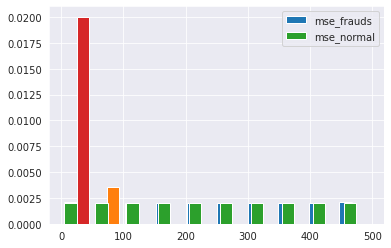

In [ ]:
#????? График построила , но не поняла что требовалось понять из него... 
x1 = np.arange(len(mse_normal[:500]))
x2 = np.arange(len(mse_frauds))

y1 = mse_normal
y2 = mse_frauds

plt.hist([x2 ,y2] , label='mse_frauds', density=True)
plt.hist([x1 ,y1] , label='mse_normal', density=True)
# plt.bar(x2 - (width/2),y2 , label='mse_fraud', width=width)
plt.legend(loc='upper right')
plt.show()


# Иссл.2

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Базы/creditcard.csv') # читаем базу

In [ ]:
df.head() # выводим первые пять строк

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Удаляем столбец со временем
data = df.drop(['Time'], axis=1)
# Нормализуем столбец с суммой транзакции
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

frauds = data[data.Class == 1] # записываем мошеннические операции
normal = data[data.Class == 0] # записываем нормальные операции

In [ ]:
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки

In [ ]:
def on_epoch_end(epoch, logs):
  predictions = model_1.predict(X_test) # делаем предсказание по X_test
  mse = np.mean(np.power(X_test - predictions, 2), axis=1) # определяем среднеквадратичную ошибку по X_test и предсказанием по X_test
  mse_normal = mse[y_test.values == 0] # среднеквадратичная ошибка на нормальных операциях
  mse_frauds = mse[y_test.values == 1] # среднеквадратичная ошибка на мошеннических операциях

  bias = 0.0
  isNormal = mse_normal < bias # если ошибка меньше порога - то транзакция нормальная
  isFrauds = mse_frauds > bias # если ошибка больше порога - то транзакция мошенническая

  accNormal = sum(isNormal) / len(isNormal) # вычисляем процент нормальных операций
  accFaruds = sum(isFrauds) / len(isFrauds) # вычисляем процент мошеннических операций
  n = round(50*(accNormal + accFaruds),1)

  for i in range(50):  
    if n <= round(50*(accNormal + accFaruds),1):
      n = round(50*(accNormal + accFaruds),1)
      bias = round(bias + 0.1, 1)
      isNormal = mse_normal < bias 
      isFrauds = mse_frauds > bias 
      accNormal = sum(isNormal) / len(isNormal) # вычисляем процент нормальных операций
      accFaruds = sum(isFrauds) / len(isFrauds) # вычисляем процент мошеннических операций  


  print()    
  print("Эпоха:", epoch+1, "/", epochs, " | ", "bias: ", bias)
  print("Распознано нормальных трансакций: ", round(100*accNormal,1), "%", sep="")
  print("Распознано мошеннических трансакций: ", round(100*accFaruds,1), "%", sep="")
  print("Средняя точность распознавания: ", n, "%", sep="")

  print("======================")
  print()

pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
epochs = 5
dataSize = X_train.shape[1] 
batchsize = dataSize
dataInput = Input(shape=(dataSize, )) 

x = Dense(dataSize, activation='relu')(dataInput) 
x = BatchNormalization()(x) 
x = Dense(15, activation='relu')(x) 
x = BatchNormalization()(x) 
x = Dense(10, activation='relu')(x) 
x = BatchNormalization()(x) 
x = Dense(15, activation='relu')(x) 
x = BatchNormalization()(x) 
x = Dense(dataSize, activation='linear')(x) 
  
model_1 = Model(inputs=dataInput, outputs=x) 
  
model_1.compile(optimizer=Adam(0.001), loss='mse') 

history = model_1.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batchsize*100,
                    verbose=0,
                    callbacks=[pltMae])


Эпоха: 1 / 5  |  bias:  1.6
Распознано нормальных трансакций: 93.2%
Распознано мошеннических трансакций: 89.0%
Средняя точность распознавания: 91.3%


Эпоха: 2 / 5  |  bias:  1.8
Распознано нормальных трансакций: 96.1%
Распознано мошеннических трансакций: 87.4%
Средняя точность распознавания: 91.8%


Эпоха: 3 / 5  |  bias:  1.7
Распознано нормальных трансакций: 96.5%
Распознано мошеннических трансакций: 87.2%
Средняя точность распознавания: 92.1%


Эпоха: 4 / 5  |  bias:  1.5
Распознано нормальных трансакций: 96.3%
Распознано мошеннических трансакций: 87.8%
Средняя точность распознавания: 92.1%


Эпоха: 5 / 5  |  bias:  1.4
Распознано нормальных трансакций: 96.5%
Распознано мошеннических трансакций: 87.4%
Средняя точность распознавания: 92.2%



In [ ]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/Базы/model_1_Credit.h5') # Сохраняем модель
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Базы/model_1_Credit.h5') # Загружаем модель